In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-for-msc-202324/seqs_train.csv
/kaggle/input/deep-learning-for-msc-202324/sample.csv
/kaggle/input/deep-learning-for-msc-202324/seqs_test.csv
/kaggle/input/deep-learning-for-msc-202324/labels_train.csv
/kaggle/input/deep-learning-for-msc-202324/test/1OGQ_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1NHI_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1R1H_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1VL5_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1JLI_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1JAD_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1R73_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1WU9_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1PAQ_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1XPP_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1EZJ_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/te

**Installing requirements**

In [5]:
!pip install ax-platform
!pip install tqdm
!pip install matplotlib
!pip install captum


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typegua

#  Imports

In [7]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import random
from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.service.utils.report_utils import exp_to_df
from ax.utils.notebook.plotting import init_notebook_plotting, render
from ax.utils.tutorials.cnn_utils import evaluate, load_mnist, train
from tqdm import tqdm
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients


# Custom Functions and Dataloader
I have arranged the additional functions I am using along with my custom loader for train set. This loader loads, pads, normalizes data, and even performs data augmentation by replacing the amino acids to enhance the model's performance on unseen data.

In [10]:
# Utility functions for various tasks
def label_encoder(label_string, custommap={'H': 0, 'E': 1, 'C': 2}):
    return np.array([custommap[ch] for ch in label_string], dtype=np.int64)


#encoding amino acids
def encoding_aminos(sequence, amino_acids='ACDEFGHIKLMNPQRSTVWY'):
    aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}
    encoded = np.zeros((len(sequence), len(amino_acids)), dtype=np.float32)
    for i, aa in enumerate(sequence):
        if aa in aa_to_idx:
            encoded[i, aa_to_idx[aa]] = 1.0
    return encoded


#function to pad
def padder(batch):
    data, labels = zip(*batch)
    data_padded = pad_sequence(data, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-1)
    return data_padded, labels_padded

#function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 2)
    correct = (predicted == labels).float()
    correct[labels == -1] = 0  
    accuracy = correct.sum() / ((labels != -1).sum().float())
    return accuracy.item()



# creating the custom data loader to load the data
class Mycustomloader(Dataset):
    def __init__(self, seqs_df, labels_df, pssm_dir, augment=False, mutation_rate=0.05):
        self.seqs_df = seqs_df
        self.labels_df = labels_df
        self.pssm_dir = pssm_dir
        self.augment = augment
        self.mutation_rate = mutation_rate
        self.amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
        
    #decided 

    def Mutate(self, sequence):
        mutated = list(sequence)
        for i in range(len(mutated)):
            if random.random() < self.mutation_rate:
                mutated[i] = random.choice(self.amino_acids)
        return ''.join(mutated)

    def __len__(self):
        return len(self.seqs_df)

    def __getitem__(self, idx):
        pdb_id = self.seqs_df.iloc[idx]['PDB_ID']
        sequence = self.seqs_df.iloc[idx]['SEQUENCE']
        if self.augment:
            sequence = self.Mutate(sequence)
        labels = self.labels_df[self.labels_df['PDB_ID'] == pdb_id]['SEC_STRUCT'].iloc[0]
        encoded_labels = label_encoder(labels)
        encoded_aa = encoding_aminos(sequence)
        pssm_path = os.path.join(self.pssm_dir, f"{pdb_id}_train.csv")
        pssm_df = pd.read_csv(pssm_path)
        pssm_numeric = pssm_df.drop(['RES_NUM', 'AMINO_ACID'], axis=1).values
        
        #Normalizing values so the model can learn better
        pssm_mean = pssm_numeric.mean(axis=0)
        pssm_std = pssm_numeric.std(axis=0) + 1e-6
        pssm_normalized = (pssm_numeric - pssm_mean) / pssm_std
        combined_features = np.hstack([encoded_aa, pssm_normalized])
        min_length = min(len(encoded_labels), combined_features.shape[0])
        combined_features = combined_features[:min_length]
        encoded_labels = encoded_labels[:min_length]
        return torch.tensor(combined_features, dtype=torch.float), torch.tensor(encoded_labels, dtype=torch.long)

#  Creating an FCN 
I have decided to create a complex FCN with batch normalization and dropouts for stability and to reduce overfitting.

In [11]:
class MYFCN(nn.Module):
    def __init__(self,kernel_size):
        super(MYFCN, self).__init__()
        padding=kernel_size//2
        self.conv1 = nn.Conv1d(in_channels=40, out_channels=64, kernel_size=kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=kernel_size, padding=padding)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.5)
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=kernel_size, padding=padding)
        self.bn4 = nn.BatchNorm1d(512)
        self.conv5 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=kernel_size, padding=padding)
        self.bn5 = nn.BatchNorm1d(512)
        self.conv6 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=kernel_size, padding=padding)
        self.bn6 = nn.BatchNorm1d(512)
        self.conv7 = nn.Conv1d(in_channels=512, out_channels=256, kernel_size=kernel_size, padding=padding)
        self.bn7 = nn.BatchNorm1d(256)
        self.conv8 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=kernel_size, padding=padding)
        self.bn8 = nn.BatchNorm1d(128)
        self.conv9 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=kernel_size, padding=padding)
        self.bn9 = nn.BatchNorm1d(64)
        self.conv10 = nn.Conv1d(in_channels=64, out_channels=3, kernel_size=kernel_size, padding=padding)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.dropout(x)
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.relu(self.bn7(self.conv7(x)))
        x = self.dropout(x)
        x = self.relu(self.bn8(self.conv8(x)))
        x = self.relu(self.bn9(self.conv9(x)))
        x = self.conv10(x)
        x = x.permute(0, 2, 1)
        return x


# The train and validation loop
This function trains the model for training and prints the train accuracy and loss for every epoch. Similarly for validation, the model is set to eval() mode ,to stop dropouts and backpropogation.

In [12]:
def train_eval(params):
    num_epochs = params.get("num_epochs", 50)  
    batch_size = params.get("batch_size", 16)  
    kernel_size = params.get("kernel_size", 3)  


    seqs_train_df = pd.read_csv('/kaggle/input/deep-learning-for-msc-202324/seqs_train.csv')
    labels_train_df = pd.read_csv('/kaggle/input/deep-learning-for-msc-202324/labels_train.csv')
    pssm_dir = '/kaggle/input/deep-learning-for-msc-202324/train'
    dataset = Mycustomloader(seqs_train_df, labels_train_df, pssm_dir, augment=True, mutation_rate=0.05)
    train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.3, random_state=42)
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=padder, num_workers=os.cpu_count())
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=padder, num_workers=os.cpu_count())
    
    model = MYFCN(kernel_size)
    criterion = nn.CrossEntropyLoss(ignore_index=-1)
    optimizer = optim.Adam(model.parameters(), lr=0.01) 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_val_accuracy = 0

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        model.train()
        train_loss_sum = 0
        train_accuracy_sum = 0
        train_total = 0

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs.reshape(-1, 3), labels.view(-1))
            loss.backward()
            optimizer.step()
            
            train_loss_sum += loss.item() * data.size(0)
            train_accuracy_sum += calculate_accuracy(outputs, labels) * data.size(0)
            train_total += data.size(0)

        train_loss_avg = train_loss_sum / train_total
        train_accuracy_avg = train_accuracy_sum / train_total

        model.eval()
        val_loss_sum = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                loss = criterion(outputs.reshape(-1, 3), labels.view(-1))
                val_loss_sum += loss.item() * data.size(0)
                val_accuracy = calculate_accuracy(outputs, labels)
                val_correct += val_accuracy * data.size(0)
                val_total += data.size(0)

        val_loss_avg = val_loss_sum / val_total
        val_accuracy = val_correct / val_total

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy

        optimizer.step()  

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss_avg:.4f}, Train Acc: {train_accuracy_avg:.4f}, Val Loss: {val_loss_avg:.4f}, Val Acc: {val_accuracy:.4f}")

    print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
    return {"val_accuracy": (best_val_accuracy, 0.0)}


# Intializing Ax
I have initialized and started the Ax trials here. Due to computational and time constraints, I couldn't conduct more trials and explore additional hyperparameters, which could have provided me with a better understanding.

In [14]:
ax_client = AxClient()
ax_client.create_experiment(
    name="AX-trail",
    parameters=[
        {"name": "num_epochs", "type": "choice", "values": [40,50], "value_type": "int"},  
        {"name": "batch_size", "type": "choice", "values": [32], "value_type": "int"},
        {"name": "kernel_size", "type": "choice", "values": [5,7], "value_type": "int"},  
    ],
   objectives={"val_accuracy": ObjectiveProperties(minimize=False)},   
)

for i in range(3):  
    parameters, trial_index = ax_client.get_next_trial()
    ax_client.complete_trial(trial_index=trial_index, raw_data=train_eval(parameters))


best_parameters = ax_client.get_best_parameters()
best_parameters_values = best_parameters[0]
print(f"Best Parameters: {best_parameters_values}")

[INFO 03-17 18:34:04] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
/opt/conda/lib/python3.10/site-packages/ax/core/parameter.py:594: UserWarning:

`is_ordered` is not specified for `ChoiceParameter` "num_epochs". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `is_ordered` during `ChoiceParameter` construction.

/opt/conda/lib/python3.10/site-packages/ax/core/parameter.py:594: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "num_epochs". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

[INFO 03-17 18:34:04] ax.service.utils.instantiation: Choice parameter batch_size contains only one value, converting to a fixed parameter 

Epoch 1/40: Train Loss: 0.8064, Train Acc: 0.6360, Val Loss: 0.6206, Val Acc: 0.7437


Epochs:   5%|▌         | 2/40 [01:05<20:52, 32.97s/it]

Epoch 2/40: Train Loss: 0.6114, Train Acc: 0.7470, Val Loss: 0.6355, Val Acc: 0.7377


Epochs:   8%|▊         | 3/40 [01:38<20:12, 32.77s/it]

Epoch 3/40: Train Loss: 0.5741, Train Acc: 0.7645, Val Loss: 0.5597, Val Acc: 0.7696


Epochs:  10%|█         | 4/40 [02:11<19:39, 32.76s/it]

Epoch 4/40: Train Loss: 0.5582, Train Acc: 0.7713, Val Loss: 0.5325, Val Acc: 0.7809


Epochs:  12%|█▎        | 5/40 [02:43<19:07, 32.78s/it]

Epoch 5/40: Train Loss: 0.5441, Train Acc: 0.7773, Val Loss: 0.5263, Val Acc: 0.7837


Epochs:  15%|█▌        | 6/40 [03:16<18:31, 32.69s/it]

Epoch 6/40: Train Loss: 0.5336, Train Acc: 0.7817, Val Loss: 0.5411, Val Acc: 0.7787


Epochs:  18%|█▊        | 7/40 [03:49<17:58, 32.68s/it]

Epoch 7/40: Train Loss: 0.5231, Train Acc: 0.7859, Val Loss: 0.5176, Val Acc: 0.7874


Epochs:  20%|██        | 8/40 [04:21<17:25, 32.69s/it]

Epoch 8/40: Train Loss: 0.5214, Train Acc: 0.7861, Val Loss: 0.5147, Val Acc: 0.7888


Epochs:  22%|██▎       | 9/40 [04:54<16:57, 32.82s/it]

Epoch 9/40: Train Loss: 0.5126, Train Acc: 0.7900, Val Loss: 0.5193, Val Acc: 0.7867


Epochs:  25%|██▌       | 10/40 [05:27<16:26, 32.87s/it]

Epoch 10/40: Train Loss: 0.5090, Train Acc: 0.7916, Val Loss: 0.5212, Val Acc: 0.7898


Epochs:  28%|██▊       | 11/40 [06:01<15:57, 33.01s/it]

Epoch 11/40: Train Loss: 0.5041, Train Acc: 0.7937, Val Loss: 0.5096, Val Acc: 0.7914


Epochs:  30%|███       | 12/40 [06:33<15:21, 32.92s/it]

Epoch 12/40: Train Loss: 0.5023, Train Acc: 0.7945, Val Loss: 0.5155, Val Acc: 0.7898


Epochs:  32%|███▎      | 13/40 [07:06<14:49, 32.96s/it]

Epoch 13/40: Train Loss: 0.4983, Train Acc: 0.7963, Val Loss: 0.5045, Val Acc: 0.7934


Epochs:  35%|███▌      | 14/40 [07:40<14:18, 33.02s/it]

Epoch 14/40: Train Loss: 0.4935, Train Acc: 0.7986, Val Loss: 0.5040, Val Acc: 0.7948


Epochs:  38%|███▊      | 15/40 [08:13<13:46, 33.06s/it]

Epoch 15/40: Train Loss: 0.4925, Train Acc: 0.7987, Val Loss: 0.5260, Val Acc: 0.7876


Epochs:  40%|████      | 16/40 [08:45<13:08, 32.86s/it]

Epoch 16/40: Train Loss: 0.4941, Train Acc: 0.7979, Val Loss: 0.5023, Val Acc: 0.7943


Epochs:  42%|████▎     | 17/40 [09:18<12:33, 32.75s/it]

Epoch 17/40: Train Loss: 0.4850, Train Acc: 0.8015, Val Loss: 0.4990, Val Acc: 0.7949


Epochs:  45%|████▌     | 18/40 [09:51<12:02, 32.84s/it]

Epoch 18/40: Train Loss: 0.4839, Train Acc: 0.8024, Val Loss: 0.4998, Val Acc: 0.7960


Epochs:  48%|████▊     | 19/40 [10:24<11:30, 32.87s/it]

Epoch 19/40: Train Loss: 0.4807, Train Acc: 0.8032, Val Loss: 0.4953, Val Acc: 0.7968


Epochs:  50%|█████     | 20/40 [10:56<10:57, 32.85s/it]

Epoch 20/40: Train Loss: 0.4772, Train Acc: 0.8051, Val Loss: 0.5109, Val Acc: 0.7901


Epochs:  52%|█████▎    | 21/40 [11:29<10:25, 32.90s/it]

Epoch 21/40: Train Loss: 0.4786, Train Acc: 0.8045, Val Loss: 0.4987, Val Acc: 0.7952


Epochs:  55%|█████▌    | 22/40 [12:02<09:52, 32.90s/it]

Epoch 22/40: Train Loss: 0.4736, Train Acc: 0.8063, Val Loss: 0.5074, Val Acc: 0.7923


Epochs:  57%|█████▊    | 23/40 [12:35<09:17, 32.80s/it]

Epoch 23/40: Train Loss: 0.4730, Train Acc: 0.8071, Val Loss: 0.4940, Val Acc: 0.7977


Epochs:  60%|██████    | 24/40 [13:08<08:45, 32.81s/it]

Epoch 24/40: Train Loss: 0.4694, Train Acc: 0.8078, Val Loss: 0.4939, Val Acc: 0.7978


Epochs:  62%|██████▎   | 25/40 [13:40<08:11, 32.75s/it]

Epoch 25/40: Train Loss: 0.4689, Train Acc: 0.8083, Val Loss: 0.5066, Val Acc: 0.7945


Epochs:  65%|██████▌   | 26/40 [14:13<07:38, 32.77s/it]

Epoch 26/40: Train Loss: 0.4678, Train Acc: 0.8092, Val Loss: 0.4925, Val Acc: 0.7986


Epochs:  68%|██████▊   | 27/40 [14:46<07:06, 32.78s/it]

Epoch 27/40: Train Loss: 0.4633, Train Acc: 0.8105, Val Loss: 0.4954, Val Acc: 0.7967


Epochs:  70%|███████   | 28/40 [15:19<06:32, 32.73s/it]

Epoch 28/40: Train Loss: 0.4638, Train Acc: 0.8104, Val Loss: 0.4923, Val Acc: 0.7999


Epochs:  72%|███████▎  | 29/40 [15:51<05:59, 32.68s/it]

Epoch 29/40: Train Loss: 0.4594, Train Acc: 0.8126, Val Loss: 0.5107, Val Acc: 0.7943


Epochs:  75%|███████▌  | 30/40 [16:24<05:26, 32.65s/it]

Epoch 30/40: Train Loss: 0.4652, Train Acc: 0.8110, Val Loss: 0.4940, Val Acc: 0.7980


Epochs:  78%|███████▊  | 31/40 [16:57<04:54, 32.67s/it]

Epoch 31/40: Train Loss: 0.4580, Train Acc: 0.8130, Val Loss: 0.4905, Val Acc: 0.7991


Epochs:  80%|████████  | 32/40 [17:29<04:21, 32.69s/it]

Epoch 32/40: Train Loss: 0.4610, Train Acc: 0.8118, Val Loss: 0.4874, Val Acc: 0.8007


Epochs:  82%|████████▎ | 33/40 [18:02<03:48, 32.67s/it]

Epoch 33/40: Train Loss: 0.4572, Train Acc: 0.8135, Val Loss: 0.4883, Val Acc: 0.8021


Epochs:  85%|████████▌ | 34/40 [18:35<03:16, 32.71s/it]

Epoch 34/40: Train Loss: 0.4561, Train Acc: 0.8140, Val Loss: 0.4877, Val Acc: 0.8015


Epochs:  88%|████████▊ | 35/40 [19:07<02:43, 32.70s/it]

Epoch 35/40: Train Loss: 0.4520, Train Acc: 0.8156, Val Loss: 0.4852, Val Acc: 0.8027


Epochs:  90%|█████████ | 36/40 [19:40<02:10, 32.64s/it]

Epoch 36/40: Train Loss: 0.4484, Train Acc: 0.8173, Val Loss: 0.4899, Val Acc: 0.8024


Epochs:  92%|█████████▎| 37/40 [20:13<01:38, 32.71s/it]

Epoch 37/40: Train Loss: 0.4502, Train Acc: 0.8164, Val Loss: 0.4938, Val Acc: 0.8001


Epochs:  95%|█████████▌| 38/40 [20:45<01:05, 32.64s/it]

Epoch 38/40: Train Loss: 0.4494, Train Acc: 0.8166, Val Loss: 0.5012, Val Acc: 0.7980


Epochs:  98%|█████████▊| 39/40 [21:18<00:32, 32.58s/it]

Epoch 39/40: Train Loss: 0.4473, Train Acc: 0.8178, Val Loss: 0.4866, Val Acc: 0.8019


Epochs: 100%|██████████| 40/40 [21:50<00:00, 32.77s/it]
[INFO 03-17 18:55:55] ax.service.ax_client: Completed trial 0 with data: {'val_accuracy': (0.802652, 0.0)}.
[INFO 03-17 18:55:55] ax.service.ax_client: Generated new trial 1 with parameters {'num_epochs': 40, 'kernel_size': 7, 'batch_size': 32} using model Sobol.


Epoch 40/40: Train Loss: 0.4490, Train Acc: 0.8166, Val Loss: 0.4903, Val Acc: 0.8026
Best Validation Accuracy: 0.8027


Epochs:   2%|▎         | 1/40 [00:37<24:08, 37.13s/it]

Epoch 1/40: Train Loss: 0.8868, Train Acc: 0.5956, Val Loss: 0.6753, Val Acc: 0.7106


Epochs:   5%|▌         | 2/40 [01:13<23:16, 36.74s/it]

Epoch 2/40: Train Loss: 0.6358, Train Acc: 0.7340, Val Loss: 0.6052, Val Acc: 0.7453


Epochs:   8%|▊         | 3/40 [01:50<22:36, 36.66s/it]

Epoch 3/40: Train Loss: 0.5768, Train Acc: 0.7624, Val Loss: 0.5605, Val Acc: 0.7707


Epochs:  10%|█         | 4/40 [02:26<22:00, 36.67s/it]

Epoch 4/40: Train Loss: 0.5585, Train Acc: 0.7707, Val Loss: 0.5625, Val Acc: 0.7668


Epochs:  12%|█▎        | 5/40 [03:03<21:19, 36.57s/it]

Epoch 5/40: Train Loss: 0.5451, Train Acc: 0.7764, Val Loss: 0.5642, Val Acc: 0.7641


Epochs:  15%|█▌        | 6/40 [03:39<20:41, 36.52s/it]

Epoch 6/40: Train Loss: 0.5291, Train Acc: 0.7832, Val Loss: 0.5339, Val Acc: 0.7810


Epochs:  18%|█▊        | 7/40 [04:16<20:11, 36.71s/it]

Epoch 7/40: Train Loss: 0.5190, Train Acc: 0.7876, Val Loss: 0.5300, Val Acc: 0.7843


Epochs:  20%|██        | 8/40 [04:53<19:38, 36.84s/it]

Epoch 8/40: Train Loss: 0.5181, Train Acc: 0.7881, Val Loss: 0.5266, Val Acc: 0.7848


Epochs:  22%|██▎       | 9/40 [05:30<19:01, 36.83s/it]

Epoch 9/40: Train Loss: 0.5147, Train Acc: 0.7900, Val Loss: 0.5343, Val Acc: 0.7814


Epochs:  25%|██▌       | 10/40 [06:07<18:25, 36.86s/it]

Epoch 10/40: Train Loss: 0.5006, Train Acc: 0.7957, Val Loss: 0.5121, Val Acc: 0.7898


Epochs:  28%|██▊       | 11/40 [06:43<17:44, 36.71s/it]

Epoch 11/40: Train Loss: 0.4976, Train Acc: 0.7968, Val Loss: 0.5258, Val Acc: 0.7870


Epochs:  30%|███       | 12/40 [07:20<17:08, 36.72s/it]

Epoch 12/40: Train Loss: 0.4920, Train Acc: 0.7987, Val Loss: 0.5166, Val Acc: 0.7887


Epochs:  32%|███▎      | 13/40 [07:57<16:34, 36.84s/it]

Epoch 13/40: Train Loss: 0.4945, Train Acc: 0.7979, Val Loss: 0.5092, Val Acc: 0.7909


Epochs:  35%|███▌      | 14/40 [08:34<15:57, 36.82s/it]

Epoch 14/40: Train Loss: 0.4878, Train Acc: 0.8006, Val Loss: 0.5490, Val Acc: 0.7772


Epochs:  38%|███▊      | 15/40 [09:11<15:17, 36.71s/it]

Epoch 15/40: Train Loss: 0.4864, Train Acc: 0.8016, Val Loss: 0.5160, Val Acc: 0.7894


Epochs:  40%|████      | 16/40 [09:47<14:38, 36.60s/it]

Epoch 16/40: Train Loss: 0.4829, Train Acc: 0.8027, Val Loss: 0.5150, Val Acc: 0.7875


Epochs:  42%|████▎     | 17/40 [10:23<13:59, 36.49s/it]

Epoch 17/40: Train Loss: 0.4829, Train Acc: 0.8022, Val Loss: 0.5080, Val Acc: 0.7929


Epochs:  45%|████▌     | 18/40 [11:00<13:23, 36.54s/it]

Epoch 18/40: Train Loss: 0.4772, Train Acc: 0.8055, Val Loss: 0.5139, Val Acc: 0.7911


Epochs:  48%|████▊     | 19/40 [11:36<12:48, 36.58s/it]

Epoch 19/40: Train Loss: 0.4736, Train Acc: 0.8064, Val Loss: 0.5158, Val Acc: 0.7900


Epochs:  50%|█████     | 20/40 [12:13<12:14, 36.70s/it]

Epoch 20/40: Train Loss: 0.4813, Train Acc: 0.8037, Val Loss: 0.5083, Val Acc: 0.7924


Epochs:  52%|█████▎    | 21/40 [12:50<11:36, 36.65s/it]

Epoch 21/40: Train Loss: 0.4711, Train Acc: 0.8075, Val Loss: 0.4987, Val Acc: 0.7962


Epochs:  55%|█████▌    | 22/40 [13:27<11:00, 36.69s/it]

Epoch 22/40: Train Loss: 0.4672, Train Acc: 0.8094, Val Loss: 0.5049, Val Acc: 0.7948


Epochs:  57%|█████▊    | 23/40 [14:04<10:25, 36.82s/it]

Epoch 23/40: Train Loss: 0.4631, Train Acc: 0.8107, Val Loss: 0.5084, Val Acc: 0.7921


Epochs:  60%|██████    | 24/40 [14:41<09:49, 36.87s/it]

Epoch 24/40: Train Loss: 0.4648, Train Acc: 0.8108, Val Loss: 0.5038, Val Acc: 0.7939


Epochs:  62%|██████▎   | 25/40 [15:17<09:10, 36.73s/it]

Epoch 25/40: Train Loss: 0.4615, Train Acc: 0.8121, Val Loss: 0.5092, Val Acc: 0.7944


Epochs:  65%|██████▌   | 26/40 [15:54<08:33, 36.67s/it]

Epoch 26/40: Train Loss: 0.4597, Train Acc: 0.8123, Val Loss: 0.5300, Val Acc: 0.7887


Epochs:  68%|██████▊   | 27/40 [16:30<07:56, 36.63s/it]

Epoch 27/40: Train Loss: 0.4567, Train Acc: 0.8140, Val Loss: 0.4999, Val Acc: 0.7973


Epochs:  70%|███████   | 28/40 [17:07<07:19, 36.59s/it]

Epoch 28/40: Train Loss: 0.4528, Train Acc: 0.8152, Val Loss: 0.5103, Val Acc: 0.7921


Epochs:  72%|███████▎  | 29/40 [17:43<06:41, 36.53s/it]

Epoch 29/40: Train Loss: 0.4561, Train Acc: 0.8140, Val Loss: 0.5022, Val Acc: 0.7972


Epochs:  75%|███████▌  | 30/40 [18:20<06:05, 36.58s/it]

Epoch 30/40: Train Loss: 0.4530, Train Acc: 0.8152, Val Loss: 0.5035, Val Acc: 0.7966


Epochs:  78%|███████▊  | 31/40 [18:56<05:28, 36.50s/it]

Epoch 31/40: Train Loss: 0.4524, Train Acc: 0.8154, Val Loss: 0.5019, Val Acc: 0.7955


Epochs:  80%|████████  | 32/40 [19:33<04:52, 36.53s/it]

Epoch 32/40: Train Loss: 0.4482, Train Acc: 0.8177, Val Loss: 0.5082, Val Acc: 0.7955


Epochs:  82%|████████▎ | 33/40 [20:09<04:15, 36.53s/it]

Epoch 33/40: Train Loss: 0.4487, Train Acc: 0.8168, Val Loss: 0.4963, Val Acc: 0.7984


Epochs:  85%|████████▌ | 34/40 [20:46<03:39, 36.51s/it]

Epoch 34/40: Train Loss: 0.4438, Train Acc: 0.8192, Val Loss: 0.5089, Val Acc: 0.7956


Epochs:  88%|████████▊ | 35/40 [21:22<03:02, 36.56s/it]

Epoch 35/40: Train Loss: 0.4498, Train Acc: 0.8170, Val Loss: 0.4989, Val Acc: 0.7978


Epochs:  90%|█████████ | 36/40 [21:59<02:26, 36.53s/it]

Epoch 36/40: Train Loss: 0.4460, Train Acc: 0.8182, Val Loss: 0.5040, Val Acc: 0.7959


Epochs:  92%|█████████▎| 37/40 [22:35<01:49, 36.49s/it]

Epoch 37/40: Train Loss: 0.4404, Train Acc: 0.8204, Val Loss: 0.5029, Val Acc: 0.7972


Epochs:  95%|█████████▌| 38/40 [23:12<01:13, 36.61s/it]

Epoch 38/40: Train Loss: 0.4417, Train Acc: 0.8200, Val Loss: 0.4981, Val Acc: 0.7985


Epochs:  98%|█████████▊| 39/40 [23:49<00:36, 36.69s/it]

Epoch 39/40: Train Loss: 0.4367, Train Acc: 0.8223, Val Loss: 0.5021, Val Acc: 0.7976


Epochs: 100%|██████████| 40/40 [24:26<00:00, 36.65s/it]
[INFO 03-17 19:20:21] ax.service.ax_client: Completed trial 1 with data: {'val_accuracy': (0.798543, 0.0)}.
[INFO 03-17 19:20:21] ax.service.ax_client: Generated new trial 2 with parameters {'num_epochs': 50, 'kernel_size': 7, 'batch_size': 32} using model Sobol.


Epoch 40/40: Train Loss: 0.4366, Train Acc: 0.8221, Val Loss: 0.5067, Val Acc: 0.7985
Best Validation Accuracy: 0.7985


Epochs:   2%|▏         | 1/50 [00:36<29:38, 36.30s/it]

Epoch 1/50: Train Loss: 0.9657, Train Acc: 0.5334, Val Loss: 0.7716, Val Acc: 0.6331


Epochs:   4%|▍         | 2/50 [01:12<29:12, 36.51s/it]

Epoch 2/50: Train Loss: 0.7001, Train Acc: 0.6944, Val Loss: 0.6491, Val Acc: 0.7334


Epochs:   6%|▌         | 3/50 [01:49<28:46, 36.74s/it]

Epoch 3/50: Train Loss: 0.6066, Train Acc: 0.7514, Val Loss: 0.6163, Val Acc: 0.7469


Epochs:   8%|▊         | 4/50 [02:26<28:11, 36.76s/it]

Epoch 4/50: Train Loss: 0.5690, Train Acc: 0.7671, Val Loss: 0.5560, Val Acc: 0.7730


Epochs:  10%|█         | 5/50 [03:03<27:29, 36.65s/it]

Epoch 5/50: Train Loss: 0.5546, Train Acc: 0.7736, Val Loss: 0.5672, Val Acc: 0.7725


Epochs:  12%|█▏        | 6/50 [03:39<26:47, 36.53s/it]

Epoch 6/50: Train Loss: 0.5371, Train Acc: 0.7809, Val Loss: 0.5392, Val Acc: 0.7799


Epochs:  14%|█▍        | 7/50 [04:16<26:13, 36.59s/it]

Epoch 7/50: Train Loss: 0.5330, Train Acc: 0.7826, Val Loss: 0.5311, Val Acc: 0.7824


Epochs:  16%|█▌        | 8/50 [04:53<25:41, 36.70s/it]

Epoch 8/50: Train Loss: 0.5190, Train Acc: 0.7885, Val Loss: 0.5279, Val Acc: 0.7843


Epochs:  18%|█▊        | 9/50 [05:29<24:59, 36.57s/it]

Epoch 9/50: Train Loss: 0.5153, Train Acc: 0.7901, Val Loss: 0.5190, Val Acc: 0.7881


Epochs:  20%|██        | 10/50 [06:06<24:25, 36.64s/it]

Epoch 10/50: Train Loss: 0.5108, Train Acc: 0.7919, Val Loss: 0.5164, Val Acc: 0.7888


Epochs:  22%|██▏       | 11/50 [06:43<23:54, 36.77s/it]

Epoch 11/50: Train Loss: 0.5082, Train Acc: 0.7926, Val Loss: 0.5214, Val Acc: 0.7871


Epochs:  24%|██▍       | 12/50 [07:20<23:18, 36.80s/it]

Epoch 12/50: Train Loss: 0.4982, Train Acc: 0.7970, Val Loss: 0.5164, Val Acc: 0.7900


Epochs:  26%|██▌       | 13/50 [07:56<22:36, 36.66s/it]

Epoch 13/50: Train Loss: 0.4961, Train Acc: 0.7975, Val Loss: 0.5161, Val Acc: 0.7882


Epochs:  28%|██▊       | 14/50 [08:32<21:57, 36.60s/it]

Epoch 14/50: Train Loss: 0.4941, Train Acc: 0.7983, Val Loss: 0.5161, Val Acc: 0.7899


Epochs:  30%|███       | 15/50 [09:09<21:16, 36.48s/it]

Epoch 15/50: Train Loss: 0.4883, Train Acc: 0.8015, Val Loss: 0.5130, Val Acc: 0.7907


Epochs:  32%|███▏      | 16/50 [09:46<20:47, 36.68s/it]

Epoch 16/50: Train Loss: 0.4860, Train Acc: 0.8018, Val Loss: 0.5150, Val Acc: 0.7892


Epochs:  34%|███▍      | 17/50 [10:22<20:10, 36.67s/it]

Epoch 17/50: Train Loss: 0.4845, Train Acc: 0.8021, Val Loss: 0.5218, Val Acc: 0.7873


Epochs:  36%|███▌      | 18/50 [11:00<19:37, 36.80s/it]

Epoch 18/50: Train Loss: 0.4785, Train Acc: 0.8048, Val Loss: 0.5196, Val Acc: 0.7892


Epochs:  38%|███▊      | 19/50 [11:36<19:00, 36.79s/it]

Epoch 19/50: Train Loss: 0.4792, Train Acc: 0.8048, Val Loss: 0.5058, Val Acc: 0.7939


Epochs:  40%|████      | 20/50 [12:13<18:22, 36.73s/it]

Epoch 20/50: Train Loss: 0.4742, Train Acc: 0.8068, Val Loss: 0.5076, Val Acc: 0.7936


Epochs:  42%|████▏     | 21/50 [12:50<17:47, 36.80s/it]

Epoch 21/50: Train Loss: 0.4745, Train Acc: 0.8066, Val Loss: 0.5086, Val Acc: 0.7929


Epochs:  44%|████▍     | 22/50 [13:26<17:07, 36.69s/it]

Epoch 22/50: Train Loss: 0.4692, Train Acc: 0.8088, Val Loss: 0.5045, Val Acc: 0.7947


Epochs:  46%|████▌     | 23/50 [14:03<16:29, 36.66s/it]

Epoch 23/50: Train Loss: 0.4696, Train Acc: 0.8085, Val Loss: 0.5019, Val Acc: 0.7941


Epochs:  48%|████▊     | 24/50 [14:40<15:58, 36.87s/it]

Epoch 24/50: Train Loss: 0.4666, Train Acc: 0.8098, Val Loss: 0.5100, Val Acc: 0.7932


Epochs:  50%|█████     | 25/50 [15:17<15:17, 36.71s/it]

Epoch 25/50: Train Loss: 0.4657, Train Acc: 0.8100, Val Loss: 0.5089, Val Acc: 0.7929


Epochs:  52%|█████▏    | 26/50 [15:53<14:39, 36.63s/it]

Epoch 26/50: Train Loss: 0.5134, Train Acc: 0.7926, Val Loss: 0.5080, Val Acc: 0.7926


Epochs:  54%|█████▍    | 27/50 [16:29<13:59, 36.52s/it]

Epoch 27/50: Train Loss: 0.4782, Train Acc: 0.8055, Val Loss: 0.5195, Val Acc: 0.7904


Epochs:  56%|█████▌    | 28/50 [17:05<13:21, 36.42s/it]

Epoch 28/50: Train Loss: 0.4722, Train Acc: 0.8079, Val Loss: 0.5298, Val Acc: 0.7847


Epochs:  58%|█████▊    | 29/50 [17:41<12:40, 36.20s/it]

Epoch 29/50: Train Loss: 0.4662, Train Acc: 0.8102, Val Loss: 0.5076, Val Acc: 0.7939


Epochs:  60%|██████    | 30/50 [18:18<12:05, 36.27s/it]

Epoch 30/50: Train Loss: 0.4631, Train Acc: 0.8116, Val Loss: 0.5118, Val Acc: 0.7917


Epochs:  62%|██████▏   | 31/50 [18:54<11:31, 36.41s/it]

Epoch 31/50: Train Loss: 0.4604, Train Acc: 0.8123, Val Loss: 0.5317, Val Acc: 0.7812


Epochs:  64%|██████▍   | 32/50 [19:31<10:55, 36.41s/it]

Epoch 32/50: Train Loss: 0.4646, Train Acc: 0.8107, Val Loss: 0.5009, Val Acc: 0.7953


Epochs:  66%|██████▌   | 33/50 [20:07<10:19, 36.44s/it]

Epoch 33/50: Train Loss: 0.4565, Train Acc: 0.8140, Val Loss: 0.5107, Val Acc: 0.7928


Epochs:  68%|██████▊   | 34/50 [20:44<09:43, 36.46s/it]

Epoch 34/50: Train Loss: 0.4569, Train Acc: 0.8140, Val Loss: 0.5160, Val Acc: 0.7916


Epochs:  70%|███████   | 35/50 [21:20<09:07, 36.49s/it]

Epoch 35/50: Train Loss: 0.4559, Train Acc: 0.8141, Val Loss: 0.5067, Val Acc: 0.7942


Epochs:  72%|███████▏  | 36/50 [21:57<08:30, 36.47s/it]

Epoch 36/50: Train Loss: 0.4539, Train Acc: 0.8154, Val Loss: 0.5133, Val Acc: 0.7930


Epochs:  74%|███████▍  | 37/50 [22:33<07:53, 36.45s/it]

Epoch 37/50: Train Loss: 0.4509, Train Acc: 0.8163, Val Loss: 0.5045, Val Acc: 0.7952


Epochs:  76%|███████▌  | 38/50 [23:10<07:19, 36.60s/it]

Epoch 38/50: Train Loss: 0.4515, Train Acc: 0.8162, Val Loss: 0.5115, Val Acc: 0.7915


Epochs:  78%|███████▊  | 39/50 [23:46<06:41, 36.49s/it]

Epoch 39/50: Train Loss: 0.4508, Train Acc: 0.8163, Val Loss: 0.5100, Val Acc: 0.7944


Epochs:  80%|████████  | 40/50 [24:22<06:03, 36.36s/it]

Epoch 40/50: Train Loss: 0.4457, Train Acc: 0.8186, Val Loss: 0.5044, Val Acc: 0.7960


Epochs:  82%|████████▏ | 41/50 [24:59<05:27, 36.36s/it]

Epoch 41/50: Train Loss: 0.4456, Train Acc: 0.8185, Val Loss: 0.5018, Val Acc: 0.7963


Epochs:  84%|████████▍ | 42/50 [25:35<04:50, 36.32s/it]

Epoch 42/50: Train Loss: 0.4467, Train Acc: 0.8181, Val Loss: 0.5023, Val Acc: 0.7966


Epochs:  86%|████████▌ | 43/50 [26:12<04:15, 36.44s/it]

Epoch 43/50: Train Loss: 0.4463, Train Acc: 0.8183, Val Loss: 0.5113, Val Acc: 0.7940


Epochs:  88%|████████▊ | 44/50 [26:48<03:39, 36.52s/it]

Epoch 44/50: Train Loss: 0.4423, Train Acc: 0.8200, Val Loss: 0.5205, Val Acc: 0.7923


Epochs:  90%|█████████ | 45/50 [27:24<03:01, 36.35s/it]

Epoch 45/50: Train Loss: 0.4486, Train Acc: 0.8174, Val Loss: 0.5045, Val Acc: 0.7950


Epochs:  92%|█████████▏| 46/50 [28:01<02:25, 36.30s/it]

Epoch 46/50: Train Loss: 0.4405, Train Acc: 0.8205, Val Loss: 0.5190, Val Acc: 0.7911


Epochs:  94%|█████████▍| 47/50 [28:37<01:48, 36.20s/it]

Epoch 47/50: Train Loss: 0.4396, Train Acc: 0.8211, Val Loss: 0.5061, Val Acc: 0.7979


Epochs:  96%|█████████▌| 48/50 [29:13<01:12, 36.22s/it]

Epoch 48/50: Train Loss: 0.4377, Train Acc: 0.8217, Val Loss: 0.5062, Val Acc: 0.7957


Epochs:  98%|█████████▊| 49/50 [29:49<00:36, 36.31s/it]

Epoch 49/50: Train Loss: 0.4345, Train Acc: 0.8234, Val Loss: 0.5069, Val Acc: 0.7977


Epochs: 100%|██████████| 50/50 [30:26<00:00, 36.53s/it]
[INFO 03-17 19:50:47] ax.service.ax_client: Completed trial 2 with data: {'val_accuracy': (0.797862, 0.0)}.


Epoch 50/50: Train Loss: 0.4324, Train Acc: 0.8242, Val Loss: 0.5133, Val Acc: 0.7965
Best Validation Accuracy: 0.7979
Best Parameters: {'num_epochs': 40, 'kernel_size': 5, 'batch_size': 32}


Although the validation accuracy was stuck at 0.78-0.80, the training accuracy was increasing very slowly as I increased the number of epochs. I decided to use a more complex architecture and limit the training to around 40-50 epochs to avoid overfitting. Since the validation accuracy plateaued, I concluded that the performance on unseen data would probably be the same.

# Training the model on full dataset with the best parameters obtained. 
After finding the best parameters, I am training the model on the entire dataset, so the model will have more data and will learn the underlying structure even better. Because of the Ax trials, I am not worried about overfitting.

Epoch 1: Full Train Loss: 0.7958, Full Train Acc: 0.6367
Epoch 2: Full Train Loss: 0.5919, Full Train Acc: 0.7583
Epoch 3: Full Train Loss: 0.5567, Full Train Acc: 0.7729
Epoch 4: Full Train Loss: 0.5328, Full Train Acc: 0.7823
Epoch 5: Full Train Loss: 0.5248, Full Train Acc: 0.7853
Epoch 6: Full Train Loss: 0.5171, Full Train Acc: 0.7886
Epoch 7: Full Train Loss: 0.5089, Full Train Acc: 0.7920
Epoch 8: Full Train Loss: 0.5032, Full Train Acc: 0.7946
Epoch 9: Full Train Loss: 0.5001, Full Train Acc: 0.7953
Epoch 10: Full Train Loss: 0.4971, Full Train Acc: 0.7971
Epoch 11: Full Train Loss: 0.4904, Full Train Acc: 0.7998
Epoch 12: Full Train Loss: 0.4877, Full Train Acc: 0.8010
Epoch 13: Full Train Loss: 0.4873, Full Train Acc: 0.8014
Epoch 14: Full Train Loss: 0.4817, Full Train Acc: 0.8035
Epoch 15: Full Train Loss: 0.4799, Full Train Acc: 0.8044
Epoch 16: Full Train Loss: 0.4775, Full Train Acc: 0.8053
Epoch 17: Full Train Loss: 0.4749, Full Train Acc: 0.8063
Epoch 18: Full Train Lo

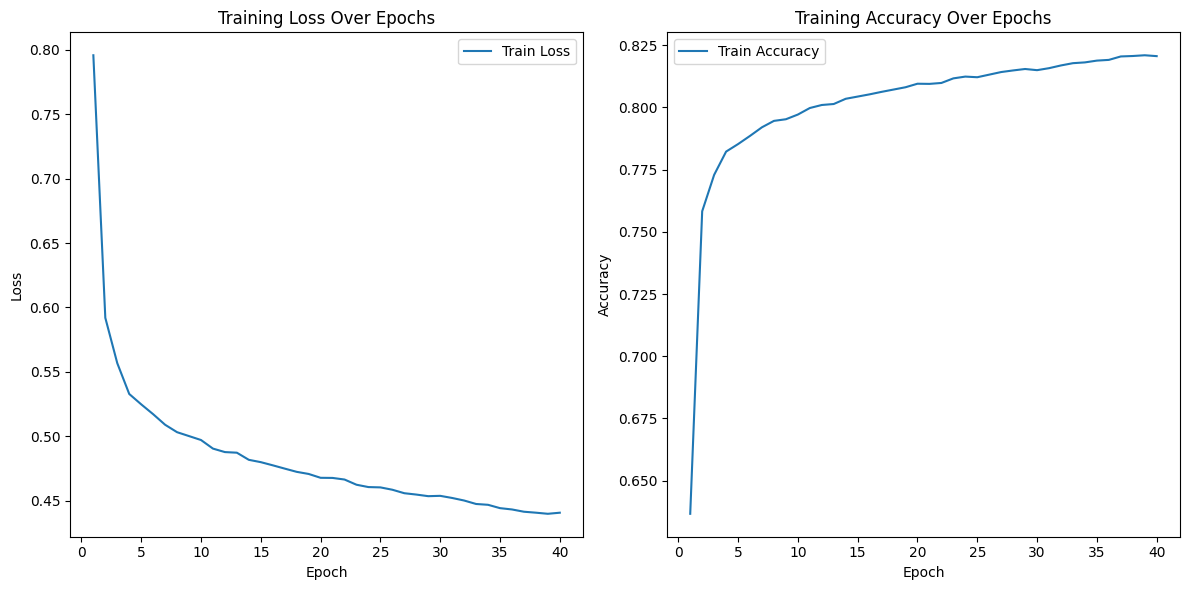

In [17]:
    num_epochs = best_parameters_values["num_epochs"] 
    batch_size = best_parameters_values["batch_size"]
    kernel_size=best_parameters_values["kernel_size"]

    seqs_train_df = pd.read_csv('/kaggle/input/deep-learning-for-msc-202324/seqs_train.csv')
    labels_train_df = pd.read_csv('/kaggle/input/deep-learning-for-msc-202324/labels_train.csv')
    pssm_dir = '/kaggle/input/deep-learning-for-msc-202324/train'
    dataset = Mycustomloader(seqs_train_df, labels_train_df, pssm_dir, augment=True, mutation_rate=0.05)
    full_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=padder, num_workers=os.cpu_count())
    model = MYFCN(kernel_size)
    criterion = nn.CrossEntropyLoss(ignore_index=-1)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        full_train_loss = 0.0
        full_train_accuracy = 0.0
        for data, labels in full_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs.reshape(-1, 3), labels.view(-1))
            loss.backward()
            optimizer.step()
            full_train_loss += loss.item()
            full_train_accuracy += calculate_accuracy(outputs, labels)

        full_train_loss /= len(full_loader)
        full_train_accuracy /= len(full_loader)

        # Record the metrics
        train_losses.append(full_train_loss)
        train_accuracies.append(full_train_accuracy)

        print(f"Epoch {epoch + 1}: Full Train Loss: {full_train_loss:.4f}, Full Train Acc: {full_train_accuracy:.4f}")

    #plotting the graph
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Finaly, predicting on test set and creating the submission.csv file

In [15]:
#Creating a custom loader, as we dont have labels, and dont have to augment data
class Custom_test_loader(Dataset):
    def __init__(self, seqs_df, pssm_dir):
        self.seqs_df = seqs_df
        self.pssm_dir = pssm_dir

    def __len__(self):
        return len(self.seqs_df)

    def __getitem__(self, idx):
        pdb_id = self.seqs_df.iloc[idx]['PDB_ID']
        sequence = self.seqs_df.iloc[idx]['SEQUENCE']
        encoded_aa = encoding_aminos(sequence)
        pssm_path = os.path.join(self.pssm_dir, f"{pdb_id}_test.csv")
        pssm_df = pd.read_csv(pssm_path)
        pssm_numeric = pssm_df.drop(['RES_NUM', 'AMINO_ACID'], axis=1).values
        pssm_mean = pssm_numeric.mean(axis=0)
        pssm_std = pssm_numeric.std(axis=0) + 1e-6
        pssm_normalized = (pssm_numeric - pssm_mean) / pssm_std
        combined_features = np.hstack([encoded_aa, pssm_normalized])
        return pdb_id, torch.tensor(combined_features, dtype=torch.float)


seqs_test_df = pd.read_csv('/kaggle/input/deep-learning-for-msc-202324/seqs_test.csv')
pssm_test_dir = '/kaggle/input/deep-learning-for-msc-202324/test'


test_dataset = Custom_test_loader(seqs_test_df, pssm_test_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  


custommap_test = {0: 'H', 1: 'E', 2: 'C'}

predictions = []


model.eval()  

with torch.no_grad():
    for pdb_id, features in test_loader:
        features = features.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 2)
        predictions.extend([(pdb_id[0], i + 1, custommap_test[label.item()]) for i, label in enumerate(predicted.squeeze())])


submission_df = pd.DataFrame(predictions, columns=['PDB_ID', 'RES_NUM', 'STRUCTURE'])
submission_df['ID'] = submission_df.apply(lambda x: f"{x['PDB_ID']}_{x['RES_NUM']}", axis=1)
submission_df = submission_df[['ID', 'STRUCTURE']]


submission_path = '/kaggle/working/submission_final.csv'
submission_df.to_csv(submission_path, index=False)
print('Submission file created, check output')

Submission file created, check output
